In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import warnings

import helpers as hlp
import helpers.features as feat
import helpers.dataset.PlantVillage as pv
import helpers.split as split
import helpers.visual_words as vw

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)
print()


#
# train/test
#
train, test = split.load(configs.split)

print("Train size:", len(train))
print("Test size:", len(test))
print()


#
# orb
#
orb_bovw = vw.load_bovw(configs.orb_bovw, None)
orb_pv_vw = vw.load_dataset_vw(configs.orb_dataset_vw,
                               None,
                               None,
                               None,
                               None)
    
print("ORB BoVW clusters:", orb_bovw.model.cluster_centers_.shape)
print("ORB PlantVillage Visual Words:", orb_pv_vw.vw_freqs.shape)
print()


#
# sift
#
sift_bovw = vw.load_bovw(configs.sift_bovw, None)
sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw,
                                None,
                                None,
                                None,
                                None)

print("Sift BoVW clusters:", sift_bovw.model.cluster_centers_.shape)
print("Sift PlantVillage Visual Words:", sift_pv_vw.vw_freqs.shape)

Dataset (60343, 5)

Train size: 3711
Test size: 928

ORB BoVW clusters: (500, 32)
ORB PlantVillage Visual Words: (4639, 500)

Sift BoVW clusters: (500, 128)
Sift PlantVillage Visual Words: (4639, 500)


In [3]:
#
# mettre le data dans une forme acceptable pour sklearn
#
train_y = pv_dataframe.loc[train, "label"]
test_y = pv_dataframe.loc[test, "label"]

# orb_pv_vw a ete construit en respectant l'ordre donne par train/test: alors faire gaffe
orb_train_x = orb_pv_vw.train_vw_freqs
orb_test_x = orb_pv_vw.test_vw_freqs

assert orb_train_x.shape[0] == train_y.shape[0]
assert orb_test_x.shape[0] == test_y.shape[0]

print("ORB PlantVillage train Visual Words", orb_train_x.shape)
print("ORB PlantVillage test Visual Words", orb_train_x.shape)

ORB PlantVillage train Visual Words (3711, 500)
ORB PlantVillage test Visual Words (3711, 500)


In [4]:
#
# KNN
#
CROSS_VALIDATION_FOLDS = 5

knn_pipe = Pipeline([("scaler", StandardScaler()),
                     ("knn", KNeighborsClassifier())])

knn_pipe_parameters = {"knn__n_neighbors": range(1, 5)}

knn_search = GridSearchCV(knn_pipe, 
                          knn_pipe_parameters, 
                          scoring="accuracy",
                          refit=True,
                          cv=CROSS_VALIDATION_FOLDS)

with warnings.catch_warnings():    
    warnings.simplefilter(action='ignore', category=FutureWarning)

    with hlp.Profile() as knn_search_time:
        knn_search.fit(orb_train_x, train_y)
    
    knn_pipe = knn_search.best_estimator_
    test_y_hat = knn_pipe.predict(orb_test_x)
    
    print("KNN best params", knn_search.best_params_)
    print("KNN search time:", knn_search_time.round_duration(), "s")
    print("KNN train score:", knn_search.best_score_.round(4))
    print("KNN test score:", accuracy_score(test_y, test_y_hat).round(4))

KNN best params {'knn__n_neighbors': 2}
KNN search time: 44.72 s
KNN train score: 0.2953
KNN test score: 0.3147


Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


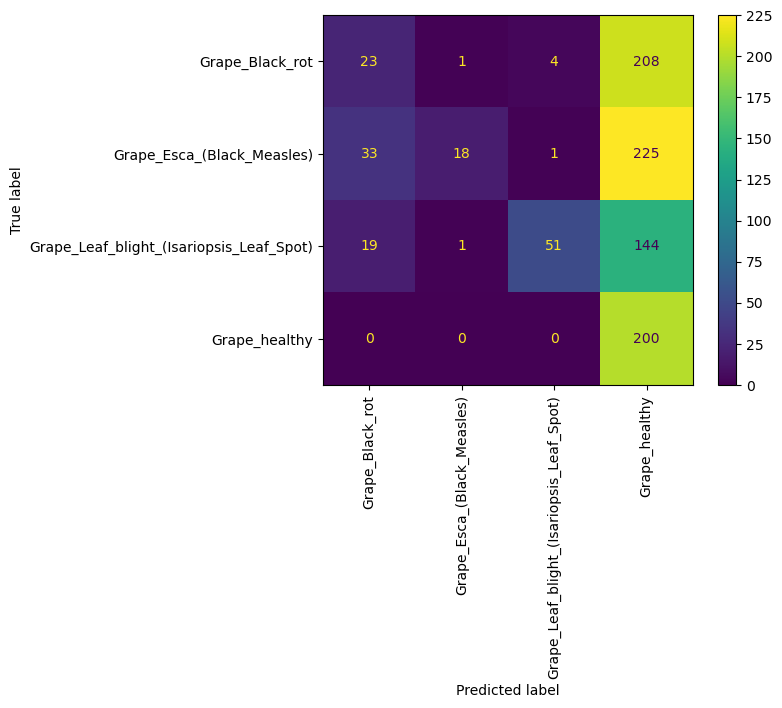

In [5]:
print( test_y.value_counts() )
cm = confusion_matrix(test_y, test_y_hat)
cm = ConfusionMatrixDisplay(cm, display_labels=knn_pipe.classes_)
cm.plot()
plt.xticks(rotation=90)
plt.show()